# **Reinforcement Learning using DQN for Atari**
### *Ranya El-Hwigi 18227449*
### *Nutsa Chichilidze 18131956*

Code runs to completion, but takes a very long time. 
Some implementation elements borrowed from: 
https://github.com/Hauf3n/DDQN-Atari-PyTorch/blob/master/DQN_Atari.ipynb and the official PyTorch documentation


In [ ]:
# installing packages necessary to train and display our network
!pip3 install scipy==1.1.0
!sudo apt-get install xvfb
!pip3 install xvfbwrapper
!apt update && apt install xvfb && pip3 install pyvirtualdisplay && pip install pyvirtualdisplay
!apt-get install x11-utils > /dev/null 2>&1 
!pip3 install pyglet > /dev/null 2>&1 
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip3 install gym pyvirtualdisplay > /dev/null 2>&1

import urllib.request
urllib.request.urlretrieve('http://www.atarimania.com/roms/Roms.rar','Roms.rar')

# importing the Atari ROMS
!pip install unrar
!unrar x Roms.rar
!mkdir rars
!mv HC\ ROMS.zip   rars
!mv ROMS.zip  rars
!python -m atari_py.import_roms rars

Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
0 upgraded, 0 newly installed, 0 to remove and 78 not upgraded.
Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bio

In [ ]:
# importing the necessary packages 
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import random
import os
import cv2
from scipy.misc import imresize
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display



In [ ]:
device = torch.device("cuda:0")
dtype = torch.float

In [ ]:
# we define an environment wrapper to handle the preprocessing of game frames
# it works by cropping, resizing and changing the color scheme of the image 
# to make the process of training simpler and more efficient. 
class Atari_Wrapper(gym.Wrapper):
    
    def __init__(self, env, env_name, k, dsize=(84,84), use_add_done=False):
      # cropping the game frames 
        super(Atari_Wrapper, self).__init__(env)
        self.dsize = dsize
        self.k = k
        self.use_add_done = use_add_done
        
        self.frame_cutout_h = (31,-16)
        self.frame_cutout_w = (7,-7)
        
    def reset(self):
      # resetting the environment 
        self.Return = 0
        self.last_life_count = 0
        
        ob = self.env.reset()
        ob = self.preprocess_observation(ob)
        
        # stack the observations k times 
        # concatenating the state space as one input
        self.frame_stack = np.stack([ob for i in range(self.k)])
        
        return self.frame_stack
    
    
    def step(self, action): 
        # skipping k frames, for every intermediate frame and stacking these frames
        reward = 0
        done = False
        additional_done = False
        
        # skip k frames or end the episode
        frames = []
        for i in range(self.k):
            
            ob, r, d, info = self.env.step(action)
            
            if self.use_add_done:
              # the agent has lost the game, signify that the game is finished 
                if info['ale.lives'] < self.last_life_count:
                    additional_done = True  
              # otherwise update the live count
                self.last_life_count = info['ale.lives']
            
            ob = self.preprocess_observation(ob)
            frames.append(ob)
            
            # increment the reward by current r
            reward += r
            
            # if the game is finished
            if d: 
                done = True
                break
                       
        # build the frame stack (observation stack)
        self.step_frame_stack(frames)
        
        self.Return += reward
        if done:
            info["return"] = self.Return
            
        # clip reward
        if reward > 0:
            reward = 1
        elif reward == 0:
            reward = 0
        else:
            reward = -1
            
        return self.frame_stack, reward, done, info, additional_done
    
    def step_frame_stack(self, frames):
        
        num_frames = len(frames)
        
        if num_frames == self.k:
            self.frame_stack = np.stack(frames)
        elif num_frames > self.k:
            self.frame_stack = np.array(frames[-k::])
            # in case that the episode is finished
        else: 
            self.frame_stack[0: self.k - num_frames] = self.frame_stack[num_frames::]
            self.frame_stack[self.k - num_frames::] = np.array(frames)  
            # adding a new frame into the frame stack
            
    # resizing the image 
    def preprocess_observation(self, ob):
    
        ob = cv2.cvtColor(ob[self.frame_cutout_h[0]:self.frame_cutout_h[1],
                           self.frame_cutout_w[0]:self.frame_cutout_w[1]], cv2.COLOR_BGR2GRAY)
        ob = cv2.resize(ob, dsize=self.dsize)
    
        return ob

In [ ]:
class DQN(nn.Module):
    # let's build the model
    # torch nn is the base class for all neural network modules 
    # therefore we are subclassing this class and reimplementing the important and necessary methods
    
    def __init__(self, in_channels, num_actions):
      # constructor for our network that inputs the input channels and the number of actins
      # in this case it's not necessary to strictly input the number of actons since we are only working on 
      # one game (breakout) 
      # however, this method can be reused for any other Atari game just by changing the number of actions as input
      # since different atari games have a different. number of actions 
        super().__init__()
      
      # the network consists of three convolution2d layers
      # it uses the ReLU activation function
      # it also uses the flattening layer as well as linear transformation layers
        network = [
            torch.nn.Conv2d(in_channels, 32, kernel_size=8, stride=4, padding=0),
            nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*7*7,512),
            nn.ReLU(),
            nn.Linear(512, num_actions)
        ]
        # the network is a sequential model
        self.network = nn.Sequential(*network)
    
    def forward(self, x):
        actions = self.network(x)
        return actions

class Agent(nn.Module):
    # agent to play the breakout game 
    def __init__(self, in_channels, num_actions, epsilon):
      # again the number of actions only passed in in case we want to play a different game in the future
      # it also inputs the input channels and the epsilon variable 
        super().__init__()
        
        self.in_channels = in_channels
        self.num_actions = num_actions
        # sets the network with the custom DQN network object we defined above  
        self.network = DQN(in_channels, num_actions)
        
        self.eps = epsilon
    
    def forward(self, x):
        actions = self.network(x)
        return actions
    
    def e_greedy(self, x):
        # epsilon greedy policy selection of actions
        # we'll sometimes use the model to choose the action
        # sometimes we will sample one uniformly
        # pytorch provides specific functions to implement this policy
        actions = self.forward(x)
        
        greedy = torch.rand(1)
        if self.eps < greedy:
            return torch.argmax(actions)
        else:
            return (torch.rand(1) * self.num_actions).type('torch.LongTensor')[0] 
        
    def greedy(self, x):
      # The greedy policy. 
      # the agent will constantly perform the action that is expected to return the highest reward
        actions = self.forward(x)
        return torch.argmax(actions)
    
    def set_epsilon(self, epsilon):
      # set the epsilon parameter for the network, which will define the probability of using a random action
      # when using the e_greedy policy approach to learning. 
        self.eps = epsilon

In [ ]:
class Logger:
    
    def __init__(self, filename):
        self.filename = filename
        
        f = open(f"{self.filename}.csv", "w")
        f.close()
        
    def log(self, msg):
        f = open(f"{self.filename}.csv", "a+")
        f.write(f"{msg}\n")
        f.close()

class Experience_Replay():
  # implementing the experience replay technique, which stores the necessary infomation about
  # the network's performance at every step of the game process. 
  # the information stored are [STATE, ACTION, REWARD, NEXT STATE] a.k.a. sars
  # this allows for a more efficient learning and better convergence behavior of the network
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def insert(self, transitions):
        # store current transition in memory
        for i in range(len(transitions)):
            if len(self.memory) < self.capacity:
                self.memory.append(None)
            self.memory[self.position] = transitions[i]
            self.position = (self.position + 1) % self.capacity

    def get(self, batch_size):
        #return random.sample(self.memory, batch_size)
        indexes = (np.random.rand(batch_size) * (len(self.memory)-1)).astype(int)
        return [self.memory[i] for i in indexes]

    def __len__(self):
        return len(self.memory)

class Env_Runner:
    
    def __init__(self, env, agent):
        super().__init__()
        
        self.env = env
        self.agent = agent
        
        self.logger = Logger("training_info")
        self.logger.log("training_step, return")
        
        self.ob = self.env.reset()
        self.total_steps = 0
        
    def run(self, steps):
        
        obs = []
        actions = []
        rewards = []
        dones = []
        
        for step in range(steps):
            
            self.ob = torch.tensor(self.ob) # uint8
            action = self.agent.e_greedy(
                self.ob.to(device).to(dtype).unsqueeze(0) / 255) # float32+norm
            action = action.detach().cpu().numpy()
            
            obs.append(self.ob)
            actions.append(action)
            
            self.ob, r, done, info, additional_done = self.env.step(action)
               
            if done: # real environment reset, other add_dones are for q learning purposes
                self.ob = self.env.reset()
                if "return" in info:
                    self.logger.log(f'{self.total_steps+step},{info["return"]}')
            
            rewards.append(r)
            dones.append(done or additional_done)
            
        self.total_steps += steps
                                    
        return obs, actions, rewards, dones
    
def make_transitions(obs, actions, rewards, dones):
    # observations are in uint8 format
    
    tuples = []

    steps = len(obs) - 1
    for t in range(steps):
        tuples.append((obs[t],
                       actions[t],
                       rewards[t],
                       obs[t+1],
                       int(not dones[t])))
        
    return tuples

In [ ]:
env_name = 'BreakoutNoFrameskip-v4'

# defining the hyper parameters

# 4 frames get stacked together, 4 is a number that's commonly used and performs better in most networks
num_stacked_frames = 4 
# defining the length of the memory that stores experience replay 
# a.k.a all the states that the network goes through as our agent plays breakout 
replay_memory_size = 250000
min_replay_size_to_update = 25000 #replay buffer 
# min_replay_size_to_update = 250 #replay buffer 

# learning rate, from research 2.5e-5 seems to be most suited for breakout bash
lr = 2.5e-5 

# the discount factor for our DQN, quantifying how much importance we 
# give for future rewards
gamma = 0.99

# batch size 
minibatch_size = 32
steps_rollout = 16

start_eps = 1
final_eps = 0.1
final_eps_frame = 1000000
total_steps = 20000000

# the more steps we allow our agent to take, the better the performace might be.
# however, we are constained by the abilities of our machines and of course, time. 
# total_steps = 1000

target_net_update = 625 # 625 - 10000 steps
# target_net_update = 62 # 625 - 10000 steps


# save_model_steps = 500000
save_model_steps = 50000

# initialize our environment with the build in gym.make functionality
raw_env = gym.make(env_name)

# update the raw environment by passing it to the wrapper we made initially 
# the wrapper allows for preprocessing the game frames for easier training 
env = Atari_Wrapper(raw_env, env_name, num_stacked_frames, use_add_done=True)

# number of input channels and actions in the game 
in_channels = num_stacked_frames
num_actions = env.action_space.n

# the interval between final and beginning epsilon score 
eps_interval = start_eps-final_eps

# initializing the original agent
agent = Agent(in_channels, num_actions, start_eps).to(device)

# defining the target agent 
# the target network is a copy of our original network, and we use it for the s and a value updates 
target_agent = Agent(in_channels, num_actions, start_eps).to(device)
target_agent.load_state_dict(agent.state_dict())

replay = Experience_Replay(replay_memory_size)
runner = Env_Runner(env, agent)

# our optimizer is Adam because it generally performs the best 
optimizer = optim.Adam(agent.parameters(), lr=lr)
huber_loss = torch.nn.SmoothL1Loss()

num_steps = 0
num_model_updates = 0

start_time = time.time()

losses = [] 

while num_steps < total_steps:
    # for each step in the game 

    # calculating the epsilon variable, setting the agent exploration to the new epsilon
    new_epsilon = np.maximum(final_eps, start_eps - ( eps_interval * num_steps/final_eps_frame))
    agent.set_epsilon(new_epsilon)
    
    # get the data at each step
    obs, actions, rewards, dones = runner.run(steps_rollout)

    # make transition is the method we defined earlier in the code
    transitions = make_transitions(obs, actions, rewards, dones)
    replay.insert(transitions)
    
    # update the number of steps 
    num_steps += steps_rollout
    
    # check if it's time to update
    if num_steps < min_replay_size_to_update:
        continue
    
    # if we have reached the point of updating, we update the observation, actions, rewards, next observbation
    for update in range(4):
        optimizer.zero_grad()
        
        minibatch = replay.get(minibatch_size)
        
        # cast to float and normalize to 0-1
        obs = (torch.stack([i[0] for i in minibatch]).to(device).to(dtype)) / 255 
        
        actions = np.stack([i[1] for i in minibatch])
        rewards = torch.tensor([i[2] for i in minibatch]).to(device)
        
        # cast to float and normalize to 0-1
        next_obs = (torch.stack([i[3] for i in minibatch]).to(device).to(dtype)) / 255
        
        dones = torch.tensor([i[4] for i in minibatch]).to(device)
        
        # Q score
        # calculating the predictions in this part 
        Qs = agent(torch.cat([obs, next_obs]))
        obs_Q, next_obs_Q = torch.split(Qs, minibatch_size ,dim=0)
        
        obs_Q = obs_Q[range(minibatch_size), actions]
        
        # target Q score
        next_obs_Q_max = torch.max(next_obs_Q,1)[1].detach()
        target_Q = target_agent(next_obs)[range(minibatch_size), next_obs_Q_max].detach()
        
        target = rewards + gamma * target_Q * dones
        
        # calculating the loss function
        # huber loss is a loss function for robust regression which is not 
        # very sensitive to outliers, therefore works well with DQNs 
        loss = huber_loss(obs_Q, target) 
        losses.append(loss) 
        # torch.mean(torch.pow(obs_Q - target, 2))
        loss.backward()
        optimizer.step()
        
    num_model_updates += 1
     
    # updating the target network
    if num_model_updates%target_net_update == 0:
        target_agent.load_state_dict(agent.state_dict())
    
    # print time
    if num_steps%50000 < steps_rollout:
        end_time = time.time()
        print(f'*** total steps: {num_steps} | time(50K): {end_time - start_time} ***')
        start_time = time.time()
    
    # save the dqn after some time
    if num_steps%save_model_steps < steps_rollout:
        torch.save(agent,f"{env_name}-{num_steps}.pt")

env.close()

In [ ]:
losses

In [ ]:
# beginning to set up the display for the game
# we let the agent play breakout and display it's performace at every frame
# this allows to evaluate the performance in real time, as well as it being entertaining 
display = Display(visible=0, size=(400, 300))
display.start()

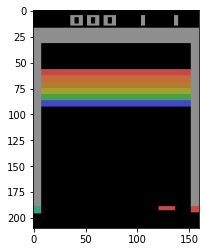

In [ ]:
# saving and loading the agent we optimized in the previous steps
torch.save(agent,"agent.pt")
agent = torch.load("agent.pt")

# reimporting the environment and rewrapping it with our custom class
# to again, preprocess the game frames for easier interaction
raw_env = gym.make(env_name)
env = Atari_Wrapper(raw_env, env_name, num_stacked_frames)

obs = env.reset()

# the number of steps again, determine how well our agent might play the game
# however - it is constrained by machine abilities and time. 
steps = 5000
# steps = 1000
agent.set_epsilon(0.025)

# evaluating the agent, this displays the structure of the network 
agent.eval()

# rendering the screen, the game will be displayed in RGB, despite being trained in grayscale
prev_screen = env.render(mode='rgb_array')

# plt allows us to display the game play on the screen
# all we are doing is plotting each frame of the game at a time
plt.imshow(prev_screen)
rewards = []

cur_reward = 0
cumulative_rewards = [] 

for i in range(steps):
  # for every step in the game we are using the epsilon greedy policy to update the 
  # action that the agent is going to take, passing in the observation from previous go
  action = agent.e_greedy(torch.tensor(obs, dtype=dtype).unsqueeze(0).to(device) / 255)
  action = action.detach().cpu().numpy()

  # loading the information from the current step
  obs, reward, done, info, _ = env.step(action)
  rewards.append(reward)

  cur_reward += reward
  cumulative_rewards.append(cur_reward) 

  # rerendering the screen to get it ready to display the next state in the game 
  screen = env.render(mode='rgb_array')
  
  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())

  # in case we are done with the game (lost or won) we simply end plotting game frames 
  if done:
    obs = env.reset()
    print(info)
    break

ipythondisplay.clear_output(wait=True)
env.close()


In [ ]:
print(agent.eval())

Agent(
  (network): DQN(
    (network): Sequential(
      (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
      (7): Linear(in_features=3136, out_features=512, bias=True)
      (8): ReLU()
      (9): Linear(in_features=512, out_features=4, bias=True)
    )
  )
)


In [ ]:
print(env.unwrapped.get_action_meanings())

['NOOP', 'FIRE', 'RIGHT', 'LEFT']


In [ ]:
print(env.observation_space.shape)

(210, 160, 3)


In [ ]:
print(losses)

[1, tensor(0.0003, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), 1, tensor(0.0004, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), 1, tensor(0.0002, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), 1, tensor(0.0002, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), 1, tensor(0.0001, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), 1, tensor(0.0001, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), 1, tensor(0.0001, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), 1, tensor(3.9841e-05, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), 1, tensor(2.9343e-05, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), 1, tensor(1.5916e-05, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), 1, tensor(1.8479e-05, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), 1, tensor(2.0378e-06, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), 1, tensor(6.1423e-07, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), 1, tensor(0.0013, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), 1, tensor

In [ ]:
print(cumulative_rewards)

In [ ]:
print(rewards)

In [ ]:
plt.plot(cumulative_rewards)

In [ ]:
losses[5]

tensor(0.0002, device='cuda:0', grad_fn=<SmoothL1LossBackward0>)

In [ ]:
losses[0].item()

0.016777437180280685

In [ ]:
loss_values = []
for loss in losses: 
  loss_values.append(loss.item())

In [ ]:
loss_values

[0.016777437180280685,
 0.00015276367776095867,
 0.01638644002377987,
 0.01615068130195141,
 0.00010679624392651021,
 5.556775431614369e-05,
 7.452061981894076e-05,
 0.00036233363789506257,
 0.00027746689738705754,
 0.000308906746795401,
 0.0003543088096193969,
 0.014855608344078064,
 0.014759424142539501,
 0.014636578038334846,
 0.0004784221819136292,
 0.00037318700924515724,
 0.0002505072043277323,
 0.0003611947176977992,
 0.00022111526050139219,
 0.0003529264940880239,
 0.00011338792683091015,
 0.000334239739459008,
 0.00016480374324601144,
 0.0003768049937207252,
 0.00034054997377097607,
 0.00035419478081166744,
 0.00041761796455830336,
 0.00031481427140533924,
 0.00038501425296999514,
 0.00037837226409465075,
 0.0003719939268194139,
 0.0003617950715124607,
 0.0002503940195310861,
 0.0002504297881387174,
 0.00023690321540925652,
 0.0002292544668307528,
 0.00019214948406443,
 0.00014878828369546682,
 0.00018576579168438911,
 0.0001321779127465561,
 0.03191746771335602,
 0.0001070171

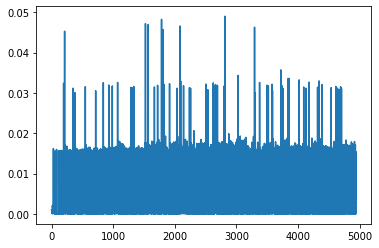

In [ ]:
plt.plot(loss_values)